# Importing Libraries

In [1]:
!pip install swifter
!pip install modin

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.0/647.0 KB 871.8 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for swifter: filename=swifter-1.1.3-py3-none-any.whl size=13078 sha256=71f61dccec8b669a58cca214058b8913aa8cd6106baedd414d5b8a71f20127b2
  Stored in directory: /root/.cache/pip/wheels/e8/1a/1b/46aa7b0fac16d3ce1bccaac14bfe4fad972642217ae78d8160
Successfully built swifter
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 761.5/761.5 KB 988.8 kB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import modin.pandas as md
import swifter
import re
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
import torch.functional as f
import torchtext.vocab as Vocab
from collections import Counter, OrderedDict
from torch.nn.utils.rnn import pad_sequence,pack_padded_sequence,pad_packed_sequence
import pytorch_lightning as pl
from tqdm import tqdm_notebook
import spacy
import torch
import os
from pytorch_lightning import callbacks
from pytorch_lightning.callbacks.progress import ProgressBarBase
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
import random
# RANDOM_SEED = 2023
# def seed_everything(seed=RANDOM_SEED):
#     os.environ['PYTHONHASHSEED'] = str(seed)
#     np.random.seed(seed)
#     random.seed(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = True    
# seed_everything()
%matplotlib inline

# Dataset

In [3]:
def text_cleaner(text):
    """
    cleans the tex
    """
    text = text.lower()
    #Replacing with urls
    text = re.sub(r"\S*https?:\S*", "url", text)
    #Replacing html text
    text = re.sub(r"<.*?>", "html", text)
    #Replacing Special chars
    text = re.sub(r"[^a-zA-Z0-9]+"," ",text)
    #Replacing numeric
    text = " ".join(["" if t.isnumeric() else t for t in text.split(" ")])
    return text

def token_maker(text,m):
    #Creating tokens
    doc = m(text)
    return [token.text for token in doc if token.text not in [" "]]

In [4]:
m = spacy.load('en_core_web_sm', disable=['ner', 'parser']) 

In [5]:
import json
f = open('../input/text-summary-news-lstm-emb256-model-2/body_vocab.json')
vocabulary1= json.load(f)
f = open('../input/text-summary-news-lstm-emb256-model-2/title_vocab.json')
vocabulary2 = json.load(f)

# Dataset Class

In [6]:
class github_class(Dataset):
    
    def __init__(self,dataset):
        self.dataset = dataset
        
    def __getitem__(self,idx):
        X = self.dataset.loc[idx]
        #X
        x = torch.tensor(X['body'])
        
        #y
        y = X['issue_title']
        y_inp = torch.tensor(y[:-1])
        y_op = torch.tensor(y[1:])
        
        return x,y_inp,y_op

    def __len__(self):
        return len(self.dataset)
    
def collate_fnc(batch):
    
    X,y_inp,y_op = zip(*batch)
    
    X_lens = [len(x) for x in X]
    y_inp_lens = [len(y) for y in y_inp]
    y_op_lens = [len(y) for y in y_op]
    
    X = pad_sequence(X,batch_first=True, padding_value=3)
    y_inp = pad_sequence(y_inp,batch_first=True, padding_value=3)
    y_op = pad_sequence(y_op,batch_first=True, padding_value=3)
    
    return X, y_inp, y_op, X_lens, y_inp_lens, y_op_lens
    
    
    

In [7]:
class Encoder(nn.Module):
    
    def __init__(self,
                 vocabulary_size,
                 embedding_size,
                 enc_hidden_size,
                 enc_out_size,
                 lstm_layers,
                 dropout):
    
        super(Encoder,self).__init__()
        self.vocabulary_size = vocabulary_size
        self.embedding_size = embedding_size
        self.lstm_layers = lstm_layers
        self.enc_hidden_size = enc_hidden_size
        self.enc_out_size = enc_out_size
        self.dropout = dropout
        
        
        self.emb = nn.Embedding(self.vocabulary_size,self.embedding_size,padding_idx =3)

        self.rnn = nn.LSTM(
                          input_size= self.embedding_size,
                          hidden_size=self.enc_hidden_size,
                          num_layers = self.lstm_layers,
                          batch_first = True,
                          dropout = self.dropout,
                          bidirectional = True
                          )
        self.normer = nn.LayerNorm(self.embedding_size)
        self.lin = nn.Linear(2*self.enc_hidden_size,self.enc_out_size)
        self.droper = nn.Dropout(p=0.5)
        self.droper1 = nn.Dropout(p=0.3)
        self.relu = nn.ReLU()
        self.normalizer = nn.LayerNorm(self.enc_out_size)
        
    def forward(self,x_pad,h=None,c=None):
        
        # Gegtting the input for the encoder and length that can be
        # used for pack and unpack the sequence 
        # x -> (B, L)
        x , x_lens = x_pad
        
        #batch size for initializing the hidden layer
        btc = x.size(0)
        
        # Embedding for the input
        # x -> (B,L) to (B,L,EMB)
        x = self.droper(self.emb(x.long()))
        
        # packing before entering in the encoder lstm
        x = pack_padded_sequence(x, x_lens, batch_first=True, enforce_sorted=False)
        
        # If not provided initially then initialize randomly
        if h==None:
            h = torch.rand((self.lstm_layers*2,btc,self.enc_hidden_size)).to('cuda')
            c = torch.rand((self.lstm_layers*2,btc,self.enc_hidden_size)).to('cuda')
        
        # passed through then encoder
        output, (h1,c1) = self.rnn(x,(h,c))
        
        # Unpack the output
        output, output_lengths = pad_packed_sequence(output, batch_first=True)
        
        # passing through linear layer
        # 
        output = self.lin(self.droper1(output))
        
        output = self.normalizer(output)
            
        # Giving out the output of the encoder and hidden states of encoder
        return output, h1, c1

In [8]:
class Attention(nn.Module):
    
    def __init__(self,
                 encoder_output_size,
                 decoder_hidden_state_size,
                 att_midsize,
                ):
        
        super(Attention,self).__init__()
        
        self.encoder_output_size = encoder_output_size
        self.decoder_hidden_state_size = 2*decoder_hidden_state_size
        self.att_midsize = att_midsize
        
        self.enc_mid_sizer = nn.Linear(encoder_output_size,self.att_midsize)
        self.dec_mid_sizer = nn.Linear(2*decoder_hidden_state_size,self.att_midsize)
        
        self.scorer = nn.Linear(self.att_midsize,1)
        
        self.tanh_act = nn.Tanh()
        
        self.softmaxer = nn.Softmax(dim=1)
        self.normalizer = nn.LayerNorm(self.att_midsize)
        
    
    def forward(self,encoder_out, decoder_state):
                
        encoder_mid = self.enc_mid_sizer(encoder_out)
#         print('encoder_mid',encoder_mid.shape,'decoder_state',decoder_state.shape)
        if decoder_state.shape[1]==2:
            
            b = torch.cat((decoder_state[:,0,:].unsqueeze(1),decoder_state[:,1,:].unsqueeze(1)),dim=-1)
            decoder_mid = self.dec_mid_sizer(b)
#             print(b.shape)
            
        else:
            decoder_mid = self.dec_mid_sizer(decoder_state)
            
#         print(encoder_mid.shape,decoder_mid.shape)
        
        add_mid = encoder_mid + decoder_mid
        
#         add_mid = self.normalizer(add_mid)
        
        add_mid = self.tanh_act(add_mid)
    
        scores = self.scorer(add_mid)
       
        scores = self.softmaxer(scores)
        
        return scores.squeeze(-1)

In [9]:
class Decoder(nn.Module):
    
    def __init__(self,
                encoder_output_size,
                decoder_hidden_state_size,
                att_mid_size,
                input_size_decoder,
                embedding_size_decoder,
                vocabulary_size,
                decoder_lstm_layers,
                decoder_dropout
                ):
        
        super(Decoder,self).__init__()
        
        self.encoder_output_size = encoder_output_size
        self.decoder_hidden_state_size = decoder_hidden_state_size
        self.att_mid_size = att_mid_size
        
        self.input_size_decoder = input_size_decoder
        self.embedding_size_decoder = embedding_size_decoder
        self.vocabulary_size = vocabulary_size
        
        self.decoder_lstm_layers = decoder_lstm_layers
        self.decoder_dropout = decoder_dropout
        
        self.attention = Attention(
                                    encoder_output_size,
                                    decoder_hidden_state_size,
                                    att_mid_size
        )
        self.decoder_embedding = nn.Embedding(self.vocabulary_size,self.input_size_decoder,padding_idx=3)
        self.context_size = self.encoder_output_size + self.input_size_decoder
        
        self.decoder_rnn = nn.LSTM(
                          input_size= self.context_size,
                          hidden_size= 2*self.decoder_hidden_state_size,
                          num_layers = self.decoder_lstm_layers,
                          batch_first = True,
                          dropout = self.decoder_dropout
                          )
        self.normer = nn.LayerNorm(self.context_size)
        self.lin = nn.Linear(2*self.decoder_hidden_state_size,self.vocabulary_size)
        self.droper = nn.Dropout(p=0.5)
        self.droper1 = nn.Dropout(p=0.3)
        
    def forward(self, encoder_ouput, decoder_prev_state, decoder_input):
        
#         decoder_input_pack = decoder_input, decoder_input_lens
        
#         decoder_input = pack_padded_sequence(decoder_input, 
#                                              decoder_input_lens, 
#                                              batch_first=True, 
#                                              enforce_sorted=False)
        
        h, c = decoder_prev_state
        h1 = h.permute(1,0,2)
        
        
        scores = self.attention(encoder_ouput,h1)
        
#         print(scores.shape)
                
        context = torch.bmm(scores.unsqueeze(1),encoder_ouput)
#         print('context',context.shape)
        
        decoder_input = self.droper(self.decoder_embedding(decoder_input.long()))
#         print('decoder_input',decoder_input.shape)

        context_input = torch.cat((context,decoder_input),dim=-1)
#         print('context_input',context_input.shape)
#         print('hc',h.shape,c.shape)
        if h.shape[0] ==2:
            bh= torch.cat((h[0,:,:].unsqueeze(0),h[1,:,:].unsqueeze(0)),dim=-1)
            bc = torch.cat((c[0,:,:].unsqueeze(0),c[1,:,:].unsqueeze(0)),dim=-1)
            output_decoder, decoder_hidden = self.decoder_rnn(context_input, 
                                                              (bh,bc))
        else:
            output_decoder, decoder_hidden = self.decoder_rnn(context_input, 
                                                              (h,c))
                                                        
#         print('output_decoder',output_decoder.shape)
        
#         output_decoder = self.lin(output_decoder)
        output_decoder = self.lin(self.droper1(output_decoder))
        return output_decoder,decoder_hidden,scores

In [10]:
encoder = Encoder(
                  len(vocabulary1),
                  embedding_size=256,
                  enc_hidden_size=512,
                  enc_out_size= 256,
                  lstm_layers=1,
                  dropout=0.2
                )
decoder = Decoder(
                encoder_output_size= 256,
                decoder_hidden_state_size = 512,
                att_mid_size = 256 ,
                input_size_decoder = 256,
                embedding_size_decoder = 256,
                vocabulary_size = len(vocabulary2) ,
                decoder_lstm_layers = 1,
                decoder_dropout= 0.2
                )

In [11]:
import pytorch_lightning as pl

class git_model(pl.LightningModule):
    
    def __init__(self,encoder,decoder):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.loss = nn.CrossEntropyLoss(ignore_index=3)
        
    def forward(self, loader):
        X, y_inp, y_op, x_lens, y_inp_lens, y_op_lens = loader
        
        encoder_output, h1, c1 = self.encoder((X,x_lens))
#         print(encoder_output.shape)
        output = []
        
        for i in range(y_inp.shape[1]):
            
            o, (h1,c1),scores = self.decoder(encoder_output,(h1,c1),y_inp[:,i].unsqueeze(1))
            
            output.append(o)
        return torch.stack(output).permute(2,1,0,3).squeeze(0) 
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=1e-4*5)
        return optimizer
    
    def training_step(self, train_batch, batch_idx):
        X, y_inp, y_op, x_lens, y_inp_lens, y_op_lens = train_batch
        
        out = self(train_batch)
        out = out.reshape(-1,len(vocabulary2))  
        
        label = y_op.reshape(-1)
        loss = self.loss(out, label.long())

        self.log('train_loss', loss)
        return loss

    def validation_step(self, val_batch, batch_idx):
        X, y_inp, y_op, x_lens, y_inp_lens, y_op_lens = val_batch
        
        out = self(val_batch)
        out = out.reshape(-1,len(vocabulary2))  
        
        label = y_op.reshape(-1)
        loss = self.loss(out, label.long())
        
        self.log('val_loss', loss)
        
        
# training
model_class = git_model(encoder,decoder)
earystopping = EarlyStopping(monitor="val_loss")




In [12]:
loss_checkpoint = callbacks.ModelCheckpoint(
            filename="best_loss",
            monitor="val_loss",
            save_top_k=1,
            mode="min",
            save_last=False,
        )
logger = TensorBoardLogger('git_model')

#---------------------------------------------------------------------------------------------------------
trainer = pl.Trainer(
                     max_epochs =50,
                     logger=logger,
                     callbacks=[earystopping,
                                loss_checkpoint],
#                     precision=16,

                    )

In [13]:
bodies = ["""Billionaire Mukesh Ambani-led Reliance Industries on Friday reported a 22.4% year-on-year rise in its consolidated net profit for Q4 2022 at ₹16,203 crore. The company's revenue from operations rose 36.79% to ₹2,11,887 crore, compared with ₹1,54,896 crore in the corresponding quarter last year. Reliance further said that its board has recommended an annual dividend of ₹8 per equity share.""",
         """The headmistress of a high school in Odisha's Ganjam was suspended after a video showing students dancing in a classroom to a song from Telugu film 'Pushpa: The Rise' surfaced on social media, District Education Officer Binita Senapati said. "Some students who were present in the classroom might have linked the TV with their mobile phones," Senapati added.""",
         ]

In [14]:
model_class = model_class.load_from_checkpoint('../input/text-summary-news-lstm-emb256-model-2/git_model/lightning_logs/version_0/checkpoints/best_loss.ckpt',encoder=encoder,decoder=decoder)
md = model_class
md = md.eval().to('cpu')

######################################################################################
______________________________________issue_____________________________________________
billionaire mukesh ambani led reliance industries on friday reported a    year on year rise in its consolidated net profit for q4 at    crore the company s revenue from operations rose    to     crore compared with     crore in the corresponding quarter last year reliance further said that its board has recommended an annual dividend of per equity share
_______________________________________machine___________________________________________
reliance profit rises to    crore in june quarter <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos

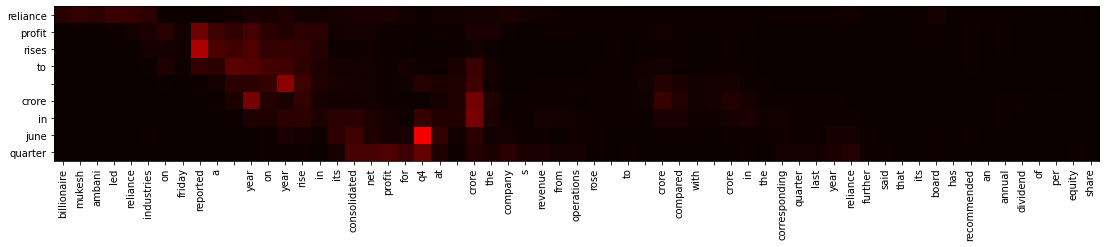

######################################################################################
______________________________________issue_____________________________________________
the <unk> of a high school in odisha s <unk> was suspended after a video showing students dancing in a classroom to a song from telugu film pushpa the rise surfaced on social media district education officer <unk> <unk> said some students who were present in the classroom might have linked the tv with their mobile phones <unk> added
_______________________________________machine___________________________________________
school principal suspended over <unk> in <unk> to <unk> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <

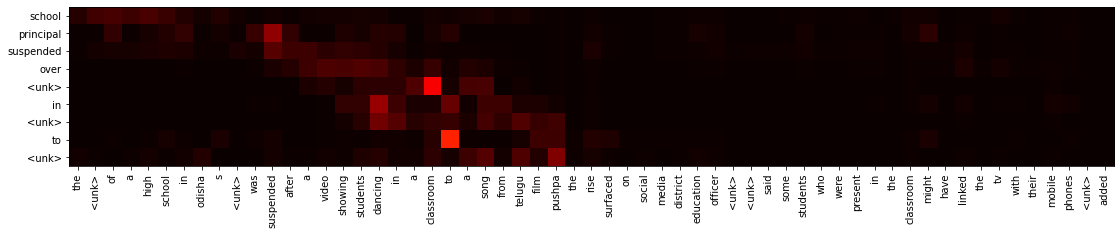

In [15]:
for body in bodies:
    print('######################################################################################')
    body= text_cleaner(body)
    m = spacy.load('en_core_web_sm', disable=['ner', 'parser']) 
    body = token_maker(body,m)
    body = [vocabulary1[token] if token in vocabulary1 else 0 for token in body]

    loader = torch.tensor(body),_,_,torch.tensor(body).shape[0]


    inv_vocabulary2 = {v: k for k, v in vocabulary2.items()}
    inv_vocabulary1 = {v: k for k, v in vocabulary1.items()}


    h = torch.rand((2*md.encoder.lstm_layers,1,md.encoder.enc_hidden_size))
    c = torch.rand((2*md.encoder.lstm_layers,1,md.encoder.enc_hidden_size))

    eo,h1,c1 = md.encoder((
                    loader[0].unsqueeze(0),
                    torch.tensor([loader[3]])
                            ),h,c)

    O = []
    S = []
    O1 = []
    S1 = []
    for j in range(200):
        if j==0:
            o, (h1,c1),scores = md.decoder(eo,(h1,c1),torch.tensor([[1.]]))
            h2,c2,o2 = h1,c1,o
            S.append(scores)
        else:
            o, (h1,c1),scores = md.decoder(eo,(h1,c1),torch.argmax(o,dim=-1))
            o2,(h2,c2),scores2 = md.decoder(eo,(h2,c2),torch.argmax(o2[:,:,1:],dim=-1)+1)
            S.append(scores)
        O.append(torch.argmax(o,dim=-1))
        O1.append(torch.argmax(o2[:,:,1:],dim=-1)+1)

    output = O
    output1= O1
    #     print(O)
    print("______________________________________issue_____________________________________________")
    print(" ".join([inv_vocabulary1[token.item()] for token in loader[0]]))
    print("_______________________________________machine___________________________________________")
    print(" ".join([inv_vocabulary2[k.item()] for k in output]))
    print("==================================================\n\n")
    print(" ".join([inv_vocabulary2[k.item()] for k in output1]))
    print("==================================================\n\n")
    
    outputs = [inv_vocabulary2[token.item()] for token in output]
    outputs = outputs[:outputs.index('<eos>')]
    import skimage.io as io
    fig, ax = plt.subplots(1,1,figsize=(15,15)) 
    io.imshow(torch.stack(S*255).reshape(-1,len(body)).detach().numpy()[:len(outputs),:],cmap='hot')
    plt.xticks(np.arange(len(body)))
    ax.set_xticklabels([inv_vocabulary1[b] for b in body],rotation=90)
    plt.yticks(np.arange(len(outputs)))
    ax.set_yticklabels(outputs)
    plt.show()
    

In [16]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
xx = pca.fit_transform(md.decoder.decoder_embedding.weight.data.detach().numpy())

In [17]:
w = []
for i in range(len(vocabulary1)):
    w.append(inv_vocabulary1[i])

In [18]:
# import plotly.express as px
# df = px.data.iris()
# fig = px.scatter_3d(x=xx[200:800,0], y=xx[200:800,1], z=xx[200:800,2],
#               text=w[200:800])
# fig.show()